# Байесовские методы

Пара интересных задачек на конец года ) Это, конечно, не основной наш контент, но под конец года хочется показать что-то нетипичное и при этом ещё больше расширяющее арсенал методов работы с данными, а также не очень скучное в плане примеров. Надеемся, всем зайдёт... а если хотите больше про Байесовские методы из первых рук, то вам [сюда](http://wiki.cs.hse.ru/%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_2021) или в более новое издание.

In [1]:
#all imports here please
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt
%matplotlib inline

## The Red Line Problem

[Оригинал](https://allendowney.github.io/ThinkBayes2/redline.html)

Адаптация: [команда ПСМО 2024](https://github.com/XuMuK1/psmo/tree/2024)

**Примечание по контенту.** Это очень красивый пример и ещё и с данными, который позволяет очень простым образом почувствовать мощь Байесовского подхода, не используя дополнительных идей. Мы основывались на одной интересной книжке, которая вдохновила сделать лекцию по байесовским методам в формате ПСМО: достаточно чёткий математически (хотя и без доказательств), а при этом с простыми примерами.
Пишется от тертьего лица и для более живого текста это не буквальный первевод, а скорее пересказ и переосмысление. Ещё некоторых деталей, которые не сошлись с автором, здесь нет.

Курсивом обозначены примечания. 

Код сделан более низкоуровневым, с одной стороны, и более привычным для контекста курса с другой.

In [2]:
#поехали

Красная ветка (Red Line) - линия метро между Кембриджем и Бостоном, Массачусетс. Когда автор работал в Кембридже, он ехал по красной ветки от Kendall Square до South Station и пересаживался на поезд в Needham. В час-пик на красной ветке поезда ездят в среднем каждые 7-8 минут.

Когда он приходил на станцию, он мог примерно оценить время до следующего поезда, основываясь на том, сколько пассажиров стоит на платформе. Если людей было мало, автор делал вывод, что только что упустил поезд и ему ещё ждать в среднем минут 7. Если много пассажиров, то поезд, вероятно, скоро приедет. Однако если пассажиров совсем много, то для него это был знак того, что поезда едут не по расписанию, поэтому он сдавался и предпочитал вызвать такси.

Пока автор ждал поезд, он подумал о том, как бы ему помогло Байесовское оценивание в предсказании времени ожидания, чтобы понять, когда ему нужно сдаться и взять такси, а когда -- подождать ещё. Это глава о том, как это было.

Этот пример основывается на проекте Брендана Риттера и Кая Остина, кто учился у автора в Olin Colledge.

Ещё до анализа нужно сделать несколько модельных предположений. Во-первых, мы будем рассматривать поток прибывающих пассажиров как Пуассоновский процесс. Это значит конкретно, что они прибывают по одному, а времена между прибытиями экспоненциальны $Exp(\lambda)$ и независимы, в среднем за минуту приходит $\lambda$ пассажиров, а число пассажиров за время $t$ имеет распределение $Pois(\lambda t)$. Формально я слежу за пассажирами короткое время каждый день в одно и то же время, поэтому можно полагать $\lambda$ константным. [*Если вам интересно, что такое Пуассоновский процесс, то записывайтесь на курсы по Случайным процессам(к примеру, [этот](http://wiki.cs.hse.ru/%D0%A1%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_(%D0%B2%D0%B5%D1%81%D0%BD%D0%B0_2024)) )*]

Параметр $\lambda$ можем считать известным, в конце концов, попробуйте оценить его из данных или... тоже по-Байесовски, если сделать $\lambda$ случайной вличиной.

С другой стороны, прибытие поездов -- не Пуассоновский процесс и вот почему. Известно, что поезда уходят по расписанию с конечной станции (Alewife station) каждые 7-8 минут в час-пик, но когда они доезжают до Kendall Square [мы здесь], время уже сильно изменчиво и интервалы движения могут составлять от 3 до 12 минут. Но мы предполагаем прибытие поезда независимым от прибытия пассажиров на платформу в интервале между поездами.

Чтобы собрать данные о времени между поездами, автор собрался и написал скрипт, загружающий реалтайм-данные с [MBTA](http://www.mbta.com/rider_tools/developers/), выбирает поезда, прибывающие на Kendall square, и сохраняет в базу данных. Скрипт запускался с 4 до 6 часов днём в течение 5 рабочих дней и записалось примерно по 15 прибытий поезда в день. Далее вычислить интервалы прибытия по этим данным -- дело техники.

Вот интервалы между поездами, в секундах.

In [143]:
observed_gap_times = np.array([
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
])
observed_gap_times = observed_gap_times / 60 #sec to min

In [144]:
observed_gap_times

array([ 7.13333333, 11.75      ,  6.78333333,  7.75      ,  7.21666667,
        7.08333333,  3.4       ,  8.43333333,  2.38333333,  5.85      ,
        7.5       ,  9.96666667,  7.73333333, 12.48333333,  5.68333333,
        9.76666667, 12.56666667,  4.26666667,  6.3       ,  7.25      ,
        2.93333333,  6.75      ,  6.        ,  8.65      , 10.8       ,
        6.23333333,  8.05      ,  8.95      ,  9.63333333,  8.9       ,
        9.61666667, 10.31666667,  8.96666667,  5.51666667,  3.1       ,
       10.48333333,  3.21666667,  6.        , 11.        ,  8.06666667,
        8.53333333,  5.25      ,  7.61666667,  6.73333333, 12.33333333,
        6.46666667,  5.95      ,  8.08333333,  9.45      ,  2.66666667,
        7.13333333,  6.45      , 15.01666667,  3.11666667, 10.36666667,
       10.26666667,  9.75      ,  7.9       ,  7.36666667,  8.31666667,
        7.28333333, 10.33333333,  5.85      ,  4.76666667,  6.21666667,
        3.86666667,  6.55      , 12.41666667, 10.6       , 12.63

### Априори

Посмотрим, на что это похоже. Но прежде всего немного технического кода для удобства.

In [145]:
class DiscreteDistribution:
    
    def __init__(self, probas, values):
        self.probas = probas
        self.values = values
        self.probas = np.exp(np.log(self.probas+1e-8) - np.log(np.sum(self.probas+1e-8)))#normalize
        
    def __str__(self):
        out = "Discrete Distribution: \n"
        out = out + "Value        Probability\n"
        out = out + "----------------------------------\n"
        for id in np.arange(len(self.values)):
            out = out + f"{self.values[id]:.3f}   |   {self.probas[id]:.3f}\n"
        out = out + "----------------------------------\n"
        return out
    
    def mean(self):
        return np.sum(self.probas*self.values)
    
    def var(self):
        return np.sum(self.probas*(self.values-self.mean())**2)
    
    def std(self):
        return np.sqrt(self.var())
    
    def sample(self, N):
        return np.random.choice(self.values,p=self.probas, replace=True, size=N)
    
        
def getKDEFromSample(sample, grid):
    kde = spstats.gaussian_kde(sample)
    ps = kde(grid)*(np.amax(grid)-np.amin(grid))/(len(grid)-1)
    pmf = DiscreteDistribution(ps, grid)
    return pmf

In [146]:
tsGrid = np.linspace(0.1, 20, 101)
pDelta0 = getKDEFromSample(observed_gap_times, tsGrid)

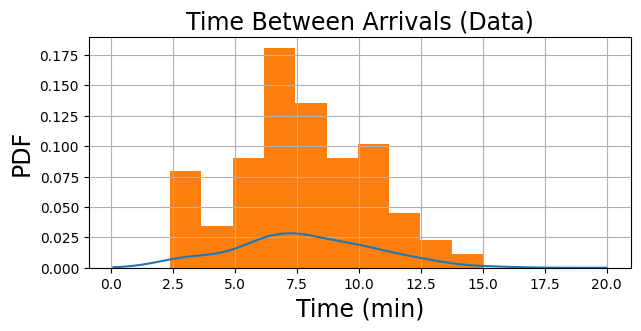

In [147]:
f, ax = plt.subplots(figsize=(7,3))

ax.grid()
ax.set_title("Time Between Arrivals (Data)", fontsize=17)
ax.set_xlabel("Time (min)", fontsize=17)
ax.set_ylabel("PDF", fontsize=17)
ax.plot(pDelta0.values, pDelta0.probas)
ax.hist(observed_gap_times, density=True)
plt.show()

Если вы ещё не видели KDE, то это знаменитая ядерная оценка плотности, или Kernel Density Estimator, частным случаем которого является [gaussian_kde](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html). Упрощённо это метод позволяющий оценить функцию плотности по данным, приближая её несколькими гауссовскими плотностями.

С помощью KDE мы получаем оценку плотности, а далее на основе неё строим приближённое дискретное распределение.

Обратите внимание, что из-за дискретизации построенный график вероятностей и гистограмма имеют разную номировку, но максимум находится в том же месте. Кроме того, KDE оценивает хвосты, которых нет в выборке.

In [148]:
print(pDelta0)

Discrete Distribution: 
Value        Probability
----------------------------------
0.100   |   0.000
0.299   |   0.001
0.498   |   0.001
0.697   |   0.001
0.896   |   0.002
1.095   |   0.002
1.294   |   0.003
1.493   |   0.003
1.692   |   0.004
1.891   |   0.005
2.090   |   0.006
2.289   |   0.006
2.488   |   0.007
2.687   |   0.008
2.886   |   0.008
3.085   |   0.009
3.284   |   0.009
3.483   |   0.010
3.682   |   0.010
3.881   |   0.011
4.080   |   0.011
4.279   |   0.012
4.478   |   0.013
4.677   |   0.014
4.876   |   0.015
5.075   |   0.016
5.274   |   0.018
5.473   |   0.019
5.672   |   0.021
5.871   |   0.023
6.070   |   0.024
6.269   |   0.025
6.468   |   0.026
6.667   |   0.027
6.866   |   0.028
7.065   |   0.028
7.264   |   0.028
7.463   |   0.028
7.662   |   0.028
7.861   |   0.027
8.060   |   0.026
8.259   |   0.026
8.458   |   0.025
8.657   |   0.024
8.856   |   0.023
9.055   |   0.023
9.254   |   0.022
9.453   |   0.021
9.652   |   0.020
9.851   |   0.020
10.050   |   0.0

На этом шаге мы оценили распределение времени прибытия поездов. Положим, мы пересчитали пассажиров, их получилось 10. Как можно уточнить распределение прибытия поезда?

Мы ответим на этот вопрос по инструкции.

Во всех выкладках мы разбиваем ось интервалов прибытия на равные отрезки, это позволяет работать с временами в дискретном виде.

### Априори

У нас есть данные (см. выше), так что стартанём с этого, как с априорного предположения. Априори вероятность прибытия с заданным интервалом дана выше.

### Дальше..?

Сложно.

Но чтобы не отчаиваться, посмотрим на факты. Мы прибыли на станцию.

* С момента последнего поезда прошло $X$ минут. Сколько -- мы не знаем. И нам ждать ещё $Y$ минут, тоже неясно, сколько.
* Пассажиров пришло $N$ и если бы мы знали $X$, то мы бы сказали, что при условии $X$ величина $N$ имеет распределение Пуассона $Pois(\lambda X)$.
* Интервал движения $\Delta = X + Y$, его мы тоже не знаем.
* Нам нужно распределение $Y$ при всех известных данных (это $N$).

Действуем пошагово, понемногу используя эти факты. Нужно $p(Y \vert N)$.

0. Начнём с $p(X \vert N)$, потому что это выглядит попроще.
1. Найдём правдоподобие $p(N \vert X)$ для формулы Байеса (это Пуассоновское).
2. Найдём распределение $p(X)$ с помощью формулы полной вероятности из априорного.
3. Выразим $p(Y \vert N)$, используя найденное.

В распределениях $X$ и $Y$ значение $x$ -- это формально время от начала интервала и от конца интервала на изначальной сетке дискретизации соответственно. Те же значения, что и в ``pDelta0``.


### Ищем распределение $X$ при условии $N$

Сразу пишем

$$
p(X=x \vert N=n) = \frac{p(N=n \vert X=x) p(X=x)}{p(N=n)}.
$$

Правдоподобие тут известно (распределение Пуассона $Pois(\lambda X)$), знаменатель можем получить нормировкой (у нас всё дискретно). Осталось найти $p(X=x)$.

### Ищем $p(X)$


Когда мы приходим на станцию мы точно не знаем, в какой интервал мы попали. Возможно, в 10-минутный, возможно, в 3-минутный. Но вообще, мы говорим о случае, когда длина интервала известна. Если так, время прибытие внутри этого интервала можно попробовать считать равномерным, потому что вообще не понятно, в какую часть интервала мы попали. То есть, если $X$ -- время прибытия внутри интервала, а размер интервала $\Delta$ дан, то

$$
p(X \vert \Delta) = \begin{cases} \frac{1}{\Delta}, & X \in [0,\Delta],\\0, & X \notin [0,\Delta]\end{cases}
$$

Это можно попробовать обосновать ещё так: если интервал времени большой, то в него проще попасть своим прибытием, можем считать вероятность попасть в промежуток $[a,a+\delta] \subset [0,\Delta]$ пропорциональной $\delta$. 

Мы используем дискретизированную версию этого распределения, дав номера каждому интервалу: то есть, при условии $\Delta=d$ величина $X$ распределена равномерно на множестве $d_0,..,d$ ( `pDelta0`).

Отсюда (эксплуатируем дискретность) по формуле полной вероятности

$$
p(X=x) = \sum_{i} p(X = x \vert \Delta = d_i) p(\Delta = d_i). 
$$

Последнее -- это наше априорное знание из данных, а первое мы с точностью до дискретизации выписали выше.

In [149]:
def make_elapsed_dist(delta, deltaValues):#author's adaptation
    qs = deltaValues[deltaValues <= delta]
    n = len(qs)
    return 1/n*np.ones_like(qs)#custom

pXunderDelta = [make_elapsed_dist(delta, pDelta0.values) for delta in pDelta0.values]
maxLen = max(len(row) for row in pXunderDelta)
pXunderDelta = np.array([np.pad(row, (0, maxLen-len(row))) for row in pXunderDelta])
pX = DiscreteDistribution( np.sum(pDelta0.probas[:,None]*pXunderDelta,axis=0), pDelta0.values)

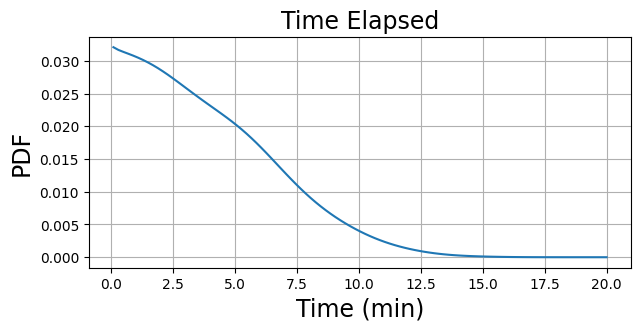

In [150]:
f, ax = plt.subplots(figsize=(7,3))

ax.grid()
ax.set_title("Time Elapsed", fontsize=17)
ax.set_xlabel("Time (min)", fontsize=17)
ax.set_ylabel("PDF", fontsize=17)
ax.plot(pX.values, pX.probas)
plt.show()

Действительно, маловероятно, что мы пришли, а поезда нет уже целых 17 минут.

Что насчёт распределения $X$ при условии $N$? Посмотрим на примере. Мы видим на платформе 10 человек и в среднем приходит 2 человека в минуту, $\lambda = 2$.

In [151]:
lam = 2
nPass = 15
pNunderX = (lam*pX.values)**nPass / (np.math.factorial(nPass)) * np.exp(-lam*pX.values)
pXunderN = DiscreteDistribution( pNunderX * pX.probas, pX.values)

C:\Temp\ipykernel_7452\844436484.py:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  pNunderX = (lam*pX.values)**nPass / (np.math.factorial(nPass)) * np.exp(-lam*pX.values)


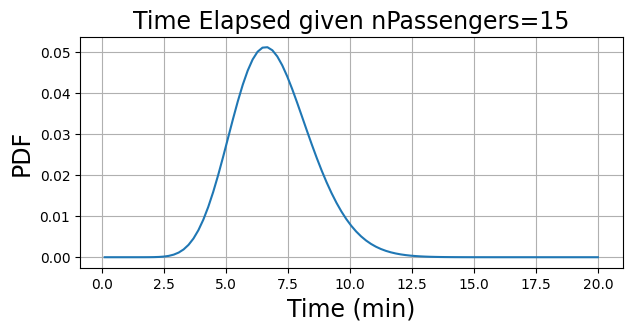

In [152]:
f, ax = plt.subplots(figsize=(7,3))

ax.grid()
ax.set_title(f"Time Elapsed given nPassengers={nPass}", fontsize=17)
ax.set_xlabel("Time (min)", fontsize=17)
ax.set_ylabel("PDF", fontsize=17)
ax.plot(pXunderN.values, pXunderN.probas)
plt.show()

Мы получили распределение прошедшего времени при условии числа пассажиров. Осталось на основе этого вычислить распределение времени ожидания.

### Сводим к $p(Y \vert N)$

По формуле полной вероятности

$$
p(Y=y \vert N=n) = p(\Delta - X =y \vert N=n) = \sum_x p(\Delta - X =y \vert X=x,~N=n) p(X=x \vert N=n)
$$

и далее

$$
p(Y=y \vert N=n) = \sum_x p(\Delta = y+x) p(X=x \vert N=n)
$$

Интервалы между поездами реализуются вне зависимости от того, сколько пассажиров сейчас на станции. При достаточно больших $x$ слагаемые будут нулевые, так как $\Delta$ ограничена. Теперь осталось посчитать.

In [121]:
pYunderN = np.array([ np.sum(pDelta0.probas[:max(len(pDelta0.probas)-i,0)]*pXunderN.probas[:max(len(pDelta0.probas)-i,0)])
                      for i in np.arange(len(pDelta0.probas)) ] )
pYunderN = DiscreteDistribution(pYunderN,pX.values)

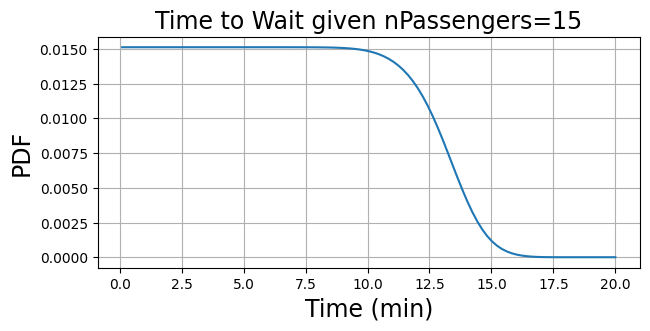

101


In [122]:
f, ax = plt.subplots(figsize=(7,3))

ax.grid()
ax.set_title(f"Time to Wait given nPassengers={nPass}", fontsize=17)
ax.set_xlabel("Time (min)", fontsize=17)
ax.set_ylabel("PDF", fontsize=17)
#ax.set_yscale("log")
ax.plot(pYunderN.values, pYunderN.probas)
plt.show()
print(len(pYunderN.values))

Маловероятно, что нам надо ждать долго, если уже есть 10 пассажиров, но насколько мы оптимистичны, показывает функция распределения.

101


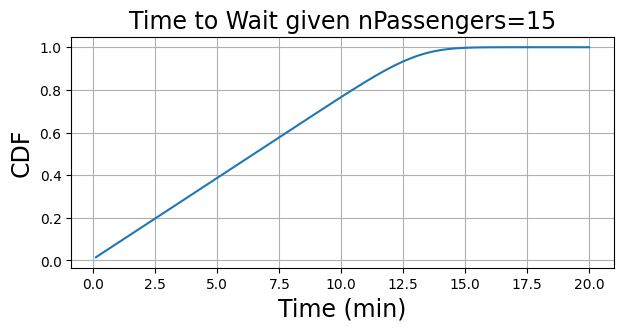

In [123]:
f, ax = plt.subplots(figsize=(7,3))

ax.grid()
ax.set_title(f"Time to Wait given nPassengers={nPass}", fontsize=17)
ax.set_xlabel("Time (min)", fontsize=17)
ax.set_ylabel("CDF", fontsize=17)
ax.plot(pYunderN.values, np.cumsum(pYunderN.probas))
print(len(pYunderN.values))
plt.show()

С вероятностью 0.8 ждать нужно меньше 10 минут. 

### Поисследуем

Чтобы получить лучший контроль и сравнить, как будет меняться апостериорное распределение при разной входной информации и разных параметрах, давайте напишем класс эксперимента, подытожив наши выкладки в компактном виде.

In [140]:
class TrainDelayModel:    
    def __init__(self,lam,deltaTsGrid):
        self.lam = lam
        self.deltaTsGrid = deltaTsGrid
        
    def _make_elapsed_dist(self, gap, qs):#author's
            qs = qs[qs <= gap]
            n = len(qs)
            return 1/n*np.ones_like(qs)#custom
        
    def fit(self, data):
        self.prior = getKDEFromSample(data, self.deltaTsGrid)
        pXunderDelta = [self._make_elapsed_dist(delta, self.prior.values) for delta in self.prior.values]
        maxLen = max(len(row) for row in pXunderDelta)
        pXunderDelta = np.array([np.pad(row, (0, maxLen-len(row))) for row in pXunderDelta])
        self.pX = DiscreteDistribution( np.sum(self.prior.probas[:,None]*pXunderDelta,axis=0), self.prior.values)
        
    def computeElapsedPosterior(self, nPassengers):
        pNunderX = np.exp( nPassengers*np.log(self.lam*self.pX.values+1e-8) - np.sum(np.log(np.arange(2,nPassengers+1))) -self.lam*self.pX.values)
        return DiscreteDistribution(pNunderX * self.pX.probas, self.pX.values)
    
    def computeToWaitPosterior(self, nPassengers):
        pXunderN = self.computeElapsedPosterior(nPassengers)
        pYunderN = np.array([ np.sum(self.prior.probas[:max(len(self.prior.probas)-i,0)]*pXunderN.probas[:max(len(self.prior.probas)-i,0)])
                      for i in np.arange(len(self.prior.probas)) ] )
        return DiscreteDistribution(pYunderN,self.pX.values)


In [141]:
modelLam2 = TrainDelayModel(2,deltaTsGrid=tsGrid)
modelLam2.fit(observed_gap_times)
nPasss = [2,5,15]
elapsedPosteriors = [modelLam2.computeElapsedPosterior(nPass) for nPass in nPasss]
toWaitPosteriors = [modelLam2.computeToWaitPosterior(nPass) for nPass in nPasss]

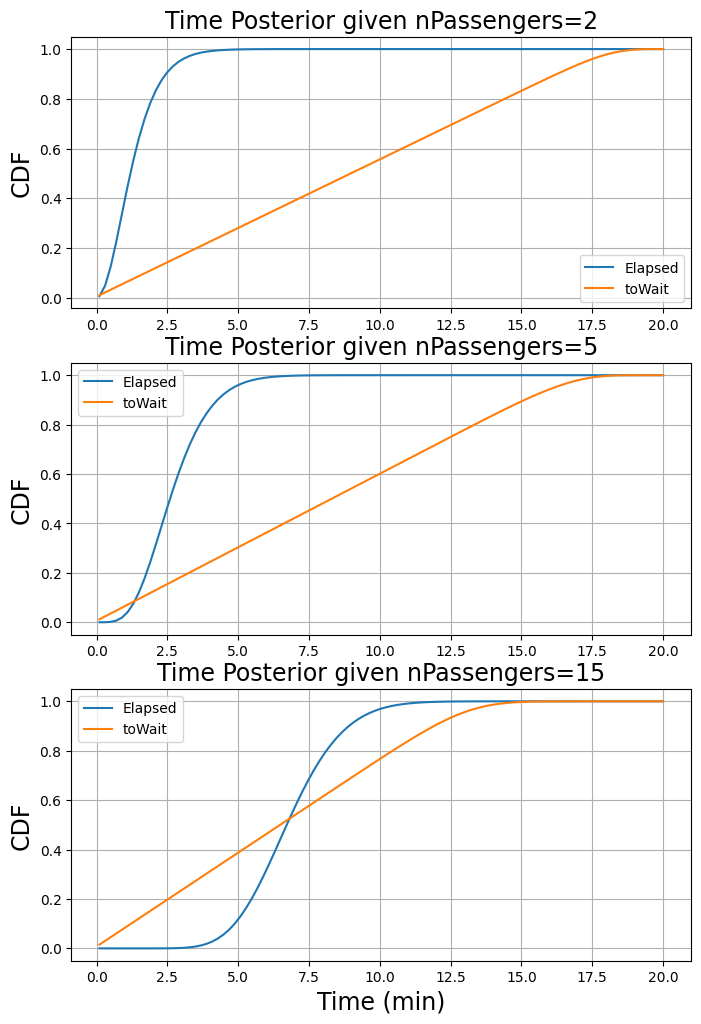

In [142]:
f, axs = plt.subplots(len(nPasss),figsize=(8,12))

for nPass in np.arange(len(nPasss)):
    axs[nPass].grid()
    axs[nPass].set_title(f"Time Posterior given nPassengers={nPasss[nPass]}", fontsize=17)
    if(nPass==len(nPasss)-1):
        axs[nPass].set_xlabel("Time (min)", fontsize=17)
    axs[nPass].set_ylabel("CDF", fontsize=17)
    axs[nPass].plot(elapsedPosteriors[nPass].values, np.cumsum(elapsedPosteriors[nPass].probas))
    axs[nPass].plot(toWaitPosteriors[nPass].values, np.cumsum(toWaitPosteriors[nPass].probas))
    axs[nPass].legend(["Elapsed","toWait"])
    
plt.show()